# kevchin - Visualizing US Covid Cases by State

## Chart and Quantify Covid Infection Curves
  * chart the normal slowing growth curves
  * determine the slope of the curve
  * compare across geographies (States and Counties)

In [1]:
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

In [2]:
%matplotlib inline
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import plotly.express as px

#import load_covid_data

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## load dataset code modified from pymc3 repo:
  * https://github.com/twiecki/covid19/blob/master/covid19_exp_model.ipynb
  * a 'narrow' format for the data
  * fewer columns and more rows

In [3]:
def load_individual_US_timeseries(name, delCols=[]):
    base_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series'
    url = f'{base_url}/time_series_covid19_{name}.csv'
    df = pd.read_csv(url, 
                        index_col=['Country_Region', 'Admin2', 
                                   'Province_State', 'Lat', 'Long_', ])
    if (len(delCols) > 0):
        extraCols = ['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Combined_Key'] + delCols
    else:
        extraCols = ['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Combined_Key']
    # Admin2 == 'City/Region' for US
    #
    df.drop(extraCols, axis=1, inplace=True)
    df['type'] = name.lower()
    df.columns.name = 'date'
    extraCols = ['Lat', 'Long_']
    df = (df.set_index('type', append=True)
                .reset_index(extraCols, drop=True)
                .stack()
                .reset_index()
                .set_index('date')
            )

    df.index = pd.to_datetime(df.index)
    df.columns = ['country', 'admin2','state', 'type', 'cases']
    return df

def add_confirmed_after_n_days_column(df, n_days=100, relevant_threshold=100):
    affected_states = df[df.cases > relevant_threshold].state.unique()
    query = (df.cases >= n_days)
    cols = ["state", "date"]
    date_since_n_lookup = dict(
        (df[query][cols].groupby("state").min().reset_index()).values
    )
    first_confirmed_date = f"first_{n_days}_confirmed_date"
    days_since = f"days_since_{n_days}"
    df[first_confirmed_date] = df.state.apply(lambda x: date_since_n_lookup.get(x))
    df[days_since] = (df.date - df[first_confirmed_date]).dt.days
    df = df.drop(columns=[first_confirmed_date])
    df = df.set_index("date")
    return df


### Load Johns Hopkins University data for Confirmed Cases
  * a wide format for the data
  * few rows and additional column per day of data

In [4]:
## Data in Long format
cases_df = load_individual_US_timeseries('confirmed_US')
cases_df = add_confirmed_after_n_days_column(cases_df.reset_index())

cityCases_df = cases_df.groupby(['state', 'admin2', 'date', 'type']).sum().reset_index()
cityCases_df = add_confirmed_after_n_days_column(cityCases_df, 100)

stateCases_df = cityCases_df.groupby(['state', 'date', 'type']).sum().reset_index()
stateCases_df = add_confirmed_after_n_days_column(stateCases_df, 100)

## Data in Wide format
confirmed_cases_us_url = 'https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv?raw=true'
confirmed_cases_url = confirmed_cases_us_url
confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')

In [5]:
cases_df.head()

,country,admin2,state,type,cases,days_since_100
date,,,,,,
2020-01-22,US,NaN,American Samoa,confirmed_us,0,NaN
2020-01-23,US,NaN,American Samoa,confirmed_us,0,NaN
2020-01-24,US,NaN,American Samoa,confirmed_us,0,NaN
2020-01-25,US,NaN,American Samoa,confirmed_us,0,NaN
2020-01-26,US,NaN,American Samoa,confirmed_us,0,NaN


In [6]:
confirmed_cases.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,"American Samoa, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,"Guam, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,177,179,179,179,179,179,180,180,183,183,183,183,185,186,188,192,200,222,222,222,225,226,231,247,247,247,253,257,267,280,280,280,280,301,303,307,309,310,310,310
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,"Northern Mariana Islands, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,24,26,26,26,27,28,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,31,31,31,31,31,31,31,31,31,33,33
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,"Puerto Rico, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4023,4508,4620,4915,4985,5046,5185,5329,5352,5536,5690,5811,5890,5951,6003,6111,6195,6463,6525,6564,6685,6820,6877,6922,7066,7189,7250,7465,7537,7608,7683,7787,7916,8585,8714,8745,8862,9137,9366,9654
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,"Virgin Islands, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,70,71,71,71,71,71,71,72,72,72,72,72,72,72,73,73,73,73,76,76,76,76,80,81,81,81,81,81,90,92,98,111,111,112,116,122,144,153,167,181


# Plot states that have flattened the curve
### Flag for using Plotly plots
  * Will default to using Plotly
  * Can set to False if you prefer

In [7]:
#plotlyChart = True
plotlyChart = False

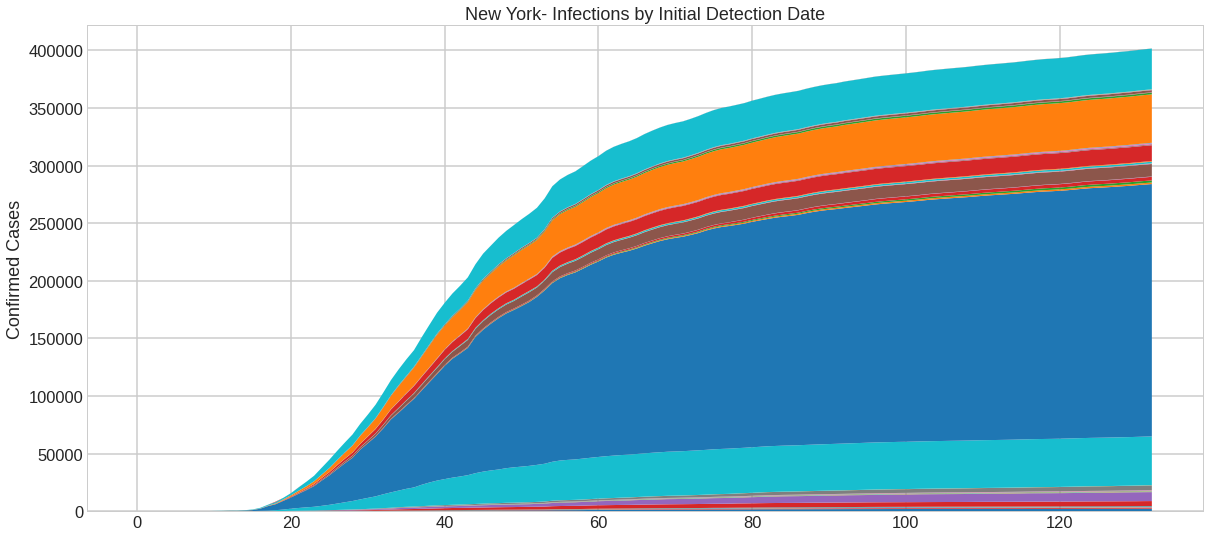

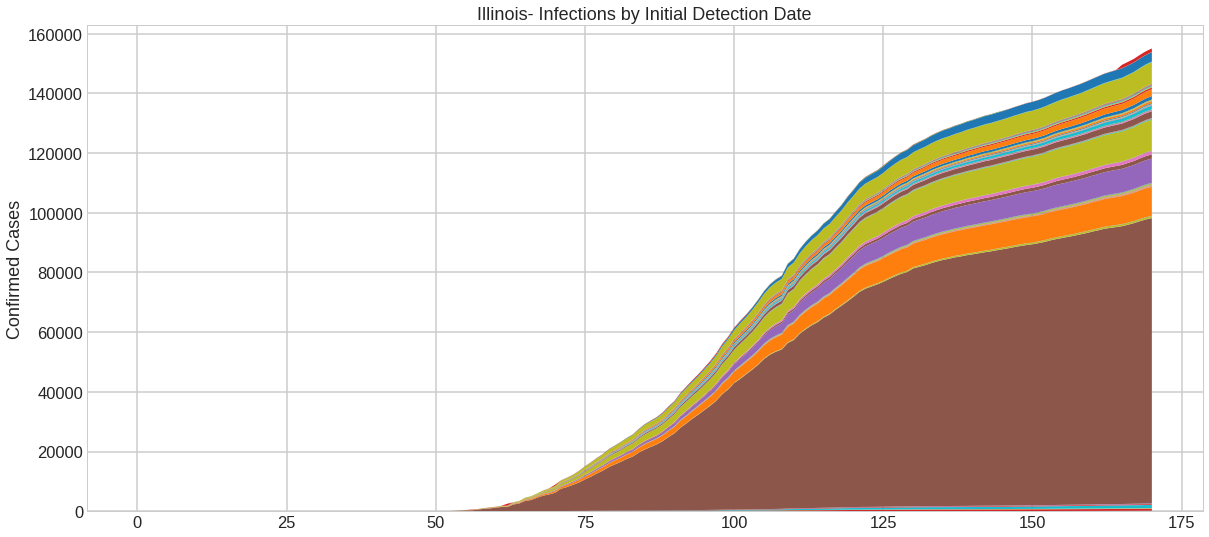

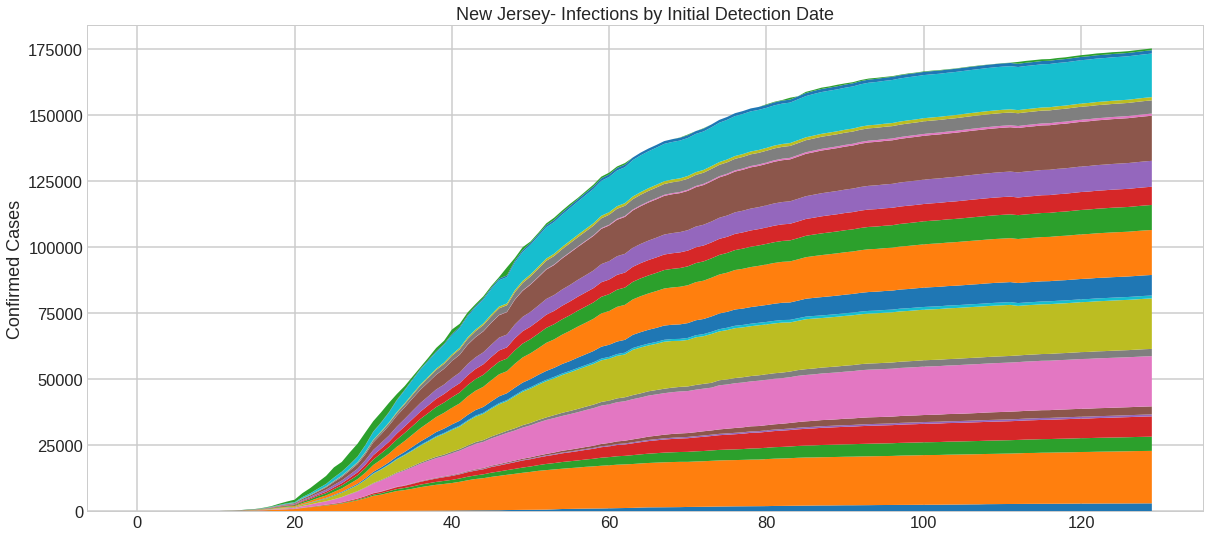

In [8]:
def plotStateGeo(stateName, title="Infections by Date", plotly=True):
  dateCols = confirmed_cases.columns.str.contains('/20')
  colList = list(confirmed_cases.columns[dateCols])
  look_df = confirmed_cases.loc[confirmed_cases["Province_State"]== stateName, 
                                dateCols].transpose()
  firstDateState = look_df.loc[look_df.sum(axis=1) > 0, ].head(1).index[0]

  slice_df = confirmed_cases.loc[confirmed_cases["Province_State"]== stateName, 
          ['Admin2'] + colList[colList.index(firstDateState):]].copy()
  
  if (plotly):
    chart_df = pd.melt(slice_df, id_vars=['Admin2'], 
                       var_name='date', value_name='cases')
    chart_df.columns = ['area', 'date', 'cases']
    chart_df['state'] = stateName
    fig = px.area(chart_df, x="date", y="cases", color="area",
	      line_group="state",
        labels={
                     "cases": "Confirmed Cases",
                     "date": "",
               },
        title=title)
    fig.update_layout(showlegend=True)
    fig.show()
  else:
    lol = slice_df[colList[colList.index(firstDateState):]].values.tolist()
    with warnings.catch_warnings():
      fig = plt.figure(figsize=(20,10))
      fig.subplots_adjust(top=0.8)
      ax1 = fig.add_subplot(111)
      ax1.set_ylabel('Confirmed Cases')
      ax1.set_xlabel('')
      ax1.set_title(title)
      x = range(len(lol[0]))
      ax1.stackplot(x, lol)

for stateName in ['New York', 'Illinois', 'New Jersey']:
  plotStateGeo(stateName, stateName+"- Infections by Initial Detection Date", plotlyChart )

In [9]:
def plotAreas(df, plotly, titleString):
  if (plotly):
    fig = px.scatter(df, x="lastN", y="change", log_x=False, size='size',
                  color='area', hover_name="area", hover_data=["size"])
    fig.update_layout(
        title=titleString,
        xaxis_title="Time (days elapsed)",
        yaxis_title="R (day over day slope)",
    )
    
    #fig.update_xaxes(autorange="reversed")
    fig.show()
  else:

    ax = sns.relplot(y="change", x="lastN",  hue='area', size="size",
                sizes=(40, 400), alpha=.5, palette="muted",
                height=6, data=df)
    ax.fig.set_size_inches(20,10)

    ax.set(xlabel="Time (days elapsed)", ylabel="R (day over day slope)", 
          title=titleString)
    #plt.gca().invert_xaxis()
    ax._legend.remove()
    plt.legend(ncol=3, prop={'size': 8})
    plt.show()

def plotStates(df, plotly, titleString):
  if (plotly):
    fig = px.scatter(df, x="lastN", y="change", log_x=False, size='size',
                  color='state', hover_name="state", hover_data=["size"])
    fig.update_layout(
        title=titleString,
        xaxis_title="Time (days elapsed)",
        yaxis_title="R (day over day slope)",
    )
    
    #fig.update_xaxes(autorange="reversed")
    fig.show()
  else:
    ax = sns.relplot(y="change", x="lastN",  hue='state', size="size",
                sizes=(40, 400), alpha=.5, palette="muted",
                height=6, data=df)
    ax.fig.set_size_inches(20,10)
    ax.set(xlabel="Time (days elapsed)", ylabel="R (day over day slope)", 
          title=titleString)
    ax._legend.remove()
    plt.legend(ncol=3, prop={'size': 8})
    #plt.gca().invert_xaxis()
    plt.show()

### Week over Week, Determine slope for last n days 
Use slope of form y = mX + B (polynomial degree = 1)
  * m = slope
  * B = intercept
  * n=14, n=30 is estimated incubation and hospitalization period respectively

Every week we calculate the slope for a window of last 'n' days.
  * if there are less than 'n' days, calculate slope for those
  * if there are more than 'n' days, take first 'n' then advance window forward 1 week

In [10]:
stateName = 'Florida'
stateLevel_df = cityCases_df.loc[cityCases_df['state'] == stateName,].copy()
lol = []
for s in stateLevel_df['admin2'].unique():
  for week in np.arange(2,20):
    days = week * 7
    slice_df = stateLevel_df.loc[stateLevel_df['admin2'] == s,].copy()
    slice_df = slice_df[slice_df["cases"] >= 100]
    since100 = len(slice_df.index)

    slice_df = slice_df.tail(days)
    l = len(slice_df.index)
    if ((l == 0) | (l >= since100)):
      continue
    
    y = slice_df.head(14)['cases']
    lastY = y[0] # cases seen at start of period
    #print (s, days, len(y), lastY,
    #       slice_df.head(1).index.values[0],
    #       slice_df.tail(1).index.values[0])

    x = np.arange(0, len(y))
    polynomialDegree = 1
    res = np.polyfit(x, np.log(y), polynomialDegree)
    # For polynomial degree 1:
    # y = res[0] * X + res[1]
    powerx = str(1+np.round(res[0],4))
    
    lol.append([s, since100, 1+np.round(res[0],4), lastY, days])

flat_df = pd.DataFrame(lol, columns=['area', 'since100','change', 'size', 'lastN'])
flat_df = flat_df.fillna(0)
flat_df = flat_df.sort_values(by=['change'], ascending=False)
flat_df = flat_df[flat_df['change'] > 0]
flat_df = flat_df.sort_values(by=['area','lastN'], ascending=[False, False])
state_area_df = flat_df.copy()
state_area_df['lastN'] = -state_area_df['lastN']
state_area_df.head()

,area,since100,change,size,lastN
541,Washington,19,1.0280,112,-14
540,Walton,52,1.0144,108,-49
539,Walton,52,1.0196,117,-42
538,Walton,52,1.0224,131,-35
537,Walton,52,1.0296,150,-28


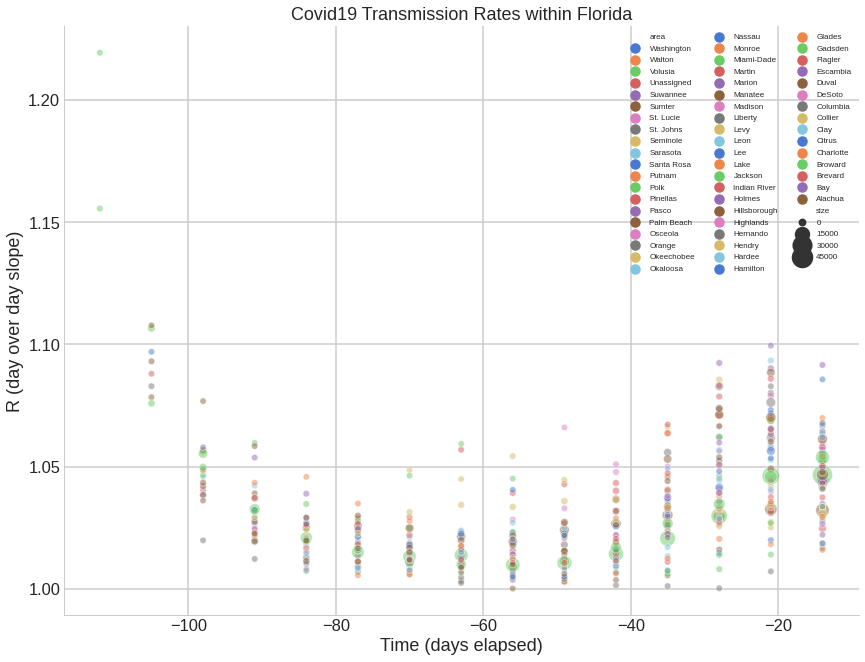

In [11]:
plotAreas (state_area_df,
            plotlyChart, "Covid19 Transmission Rates within "+ stateName)

In [12]:
lol = []
for s in stateCases_df['state'].unique():
  for week in np.arange(2,20):
    days = week * 7
    slice_df = stateCases_df.loc[stateCases_df['state'] == s,].copy()
    slice_df = slice_df[slice_df["cases"] >= 100]
    since100 = len(slice_df.index)

    slice_df = slice_df.tail(days).copy()
    l = len(slice_df.index)
    if ((l == 0) | (l >= since100)):
      continue
    
    y = slice_df.head(14)['cases']
    lastY = y[0] # cases seen at start of period
    x = np.arange(0, len(y))
    polynomialDegree = 1
    res = np.polyfit(x, np.log(y), polynomialDegree)
    # For polynomial degree 1:
    # y = res[0] * X + res[1]
    powerx = str(1+np.round(res[0],4))
    
    lol.append([s, since100, 1+np.round(res[0],4), lastY, days])

flat_df = pd.DataFrame(lol, columns=['state', 'since100','change', 'size', 'lastN'])
flat_df = flat_df.fillna(0)
flat_df = flat_df.sort_values(by=['change'], ascending=False)
flat_df = flat_df[flat_df['change'] > 0]
flat_df = flat_df.sort_values(by=['state','lastN'], ascending=[False, False])
states_all_df = flat_df.copy()
states_all_df['lastN'] = -states_all_df['lastN']

In [13]:
#states_all_df.loc[states_all_df['state'] == 'Florida',].head(20)

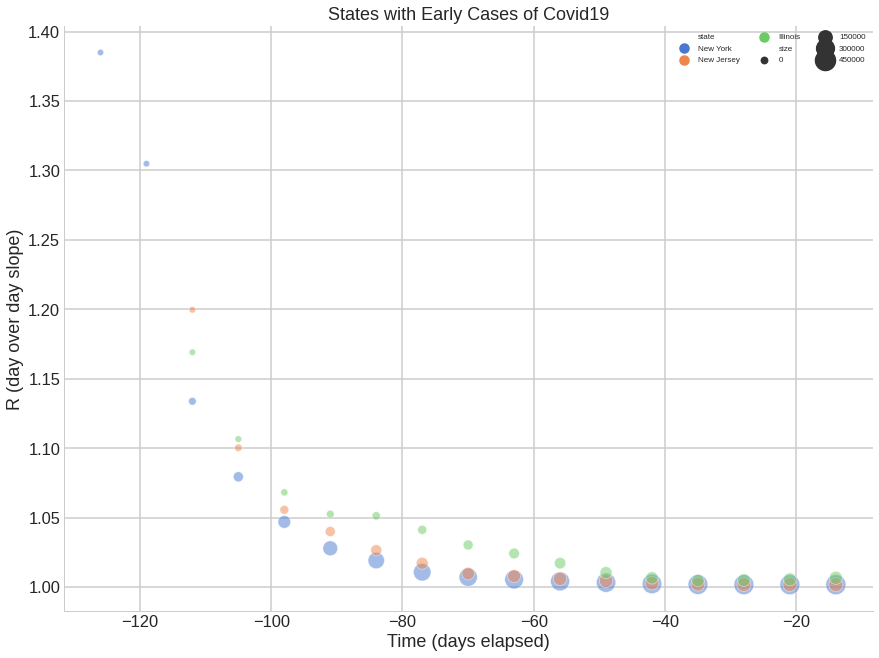

In [14]:
stateList = ['New York', 'Illinois', 'New Jersey']
plotStates (states_all_df.loc[states_all_df['state'].isin(stateList),],
            plotlyChart, "States with Early Cases of Covid19")

## Approximate the rate of change
  * look at last 'N' days
    * N=14 and N=30 might be interesting
  * sum up % change over that period
  * sort by that sum

In [15]:
def measureChange(stateName, lastN=30): 
    l = (stateCases_df['state'] == stateName) & (stateCases_df['cases'] > 0)
    return (stateCases_df.loc[l,'cases'].pct_change()[-lastN:].sum())

d = {"states": pd.Series(stateCases_df['state'].unique())}
ranked_df = pd.DataFrame(d)

nDays = 14
ranked_df['rate'] = ranked_df.apply(lambda row : 
                                    measureChange(row['states'], nDays), axis=1)
ranked_df = ranked_df.sort_values(by='rate')
ranked_df.head()

,states,rate
6,Connecticut,0.021059
32,New York,0.023105
30,New Jersey,0.023782
21,Massachusetts,0.026634
39,Rhode Island,0.038434


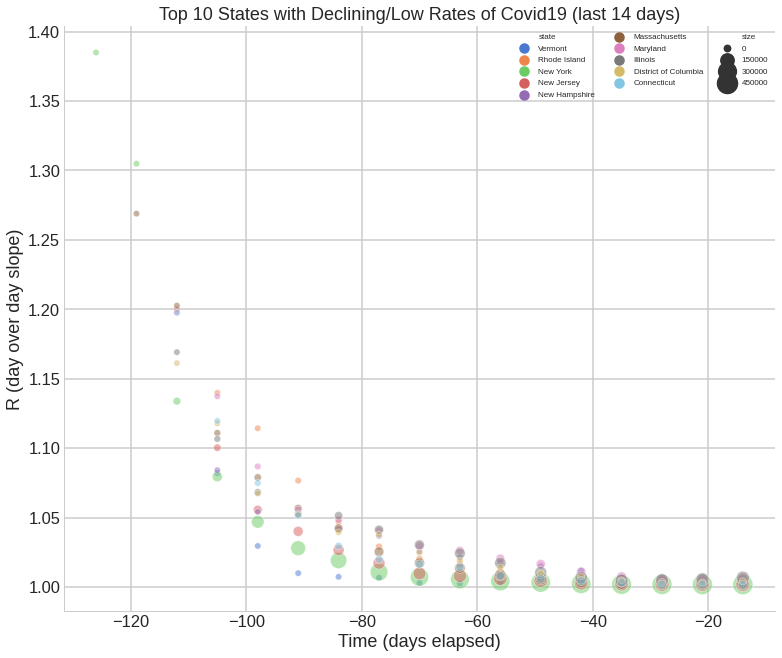

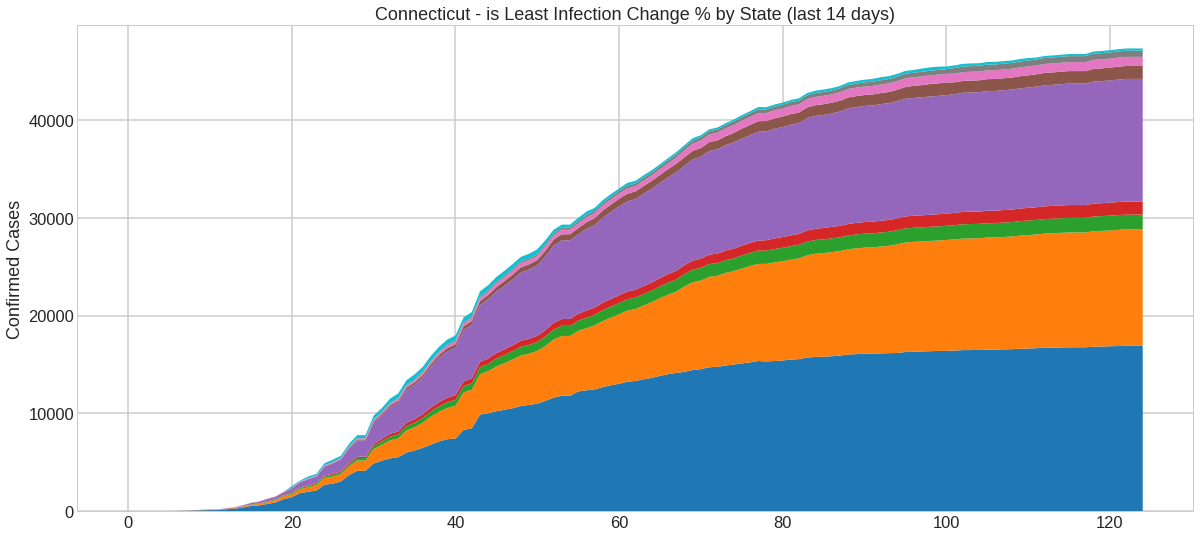

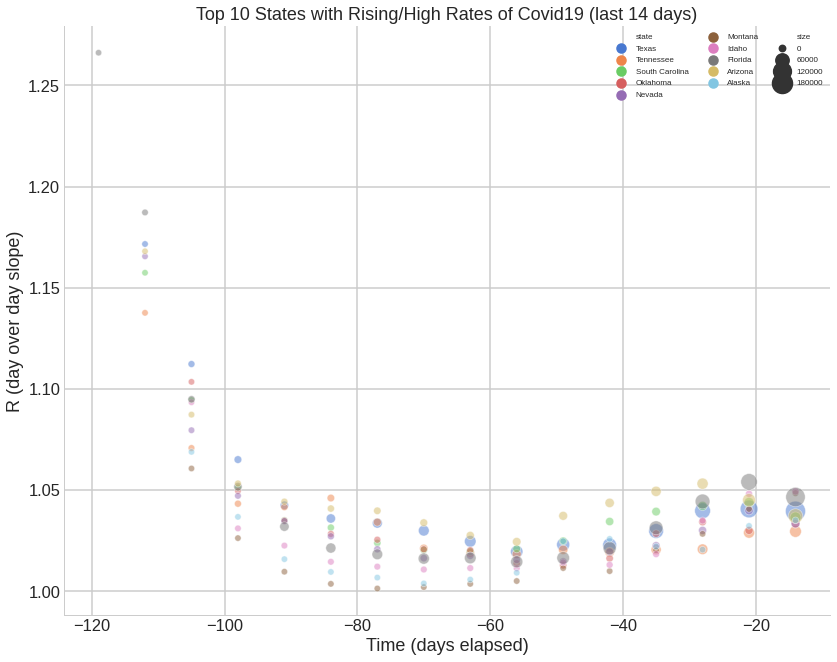

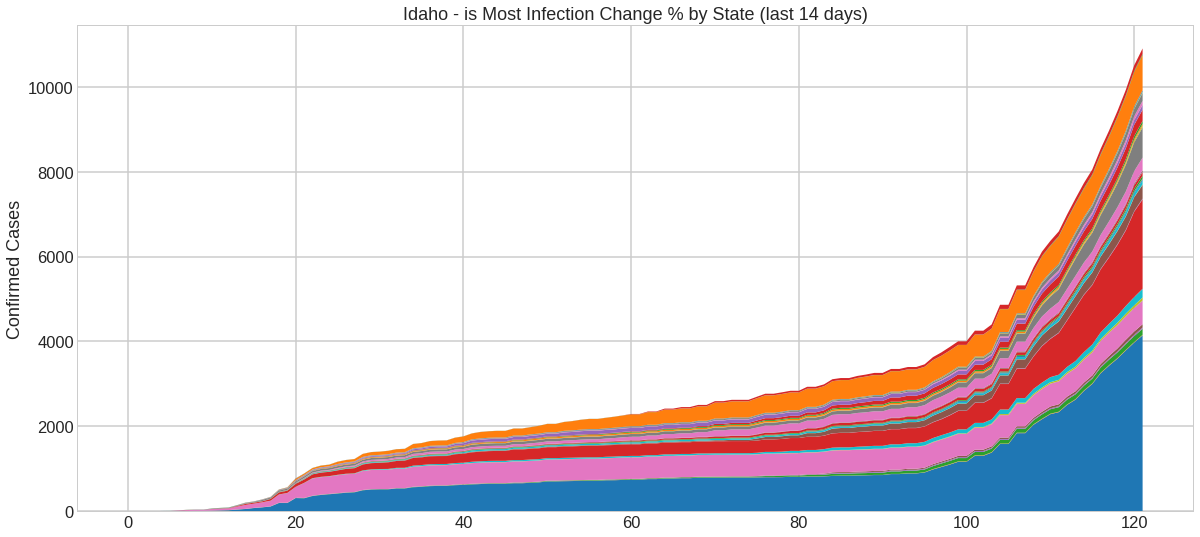

In [16]:
stateList = ranked_df.head(10)['states']
stateCount = len(stateList)
plotStates (states_all_df.loc[states_all_df['state'].isin(stateList),],
            plotlyChart, "Top "+ str(stateCount) 
            +" States with Declining/Low Rates of Covid19 (last "+str(nDays)+" days)")

topState = ranked_df.head(1).iloc[0]['states']
plotStateGeo(topState, topState+' - is Least Infection Change % by State (last '+str(nDays)+" days)" , plotlyChart)

stateList = ranked_df.tail(10)['states']
plotStates (states_all_df.loc[states_all_df['state'].isin(stateList),],
            plotlyChart, "Top "+ str(stateCount) 
            +" States with Rising/High Rates of Covid19 (last "+str(nDays)+" days)")

topState = ranked_df.tail(1).iloc[0]['states']
plotStateGeo(topState, topState+' - is Most Infection Change % by State (last '+str(nDays)+" days)", plotlyChart)



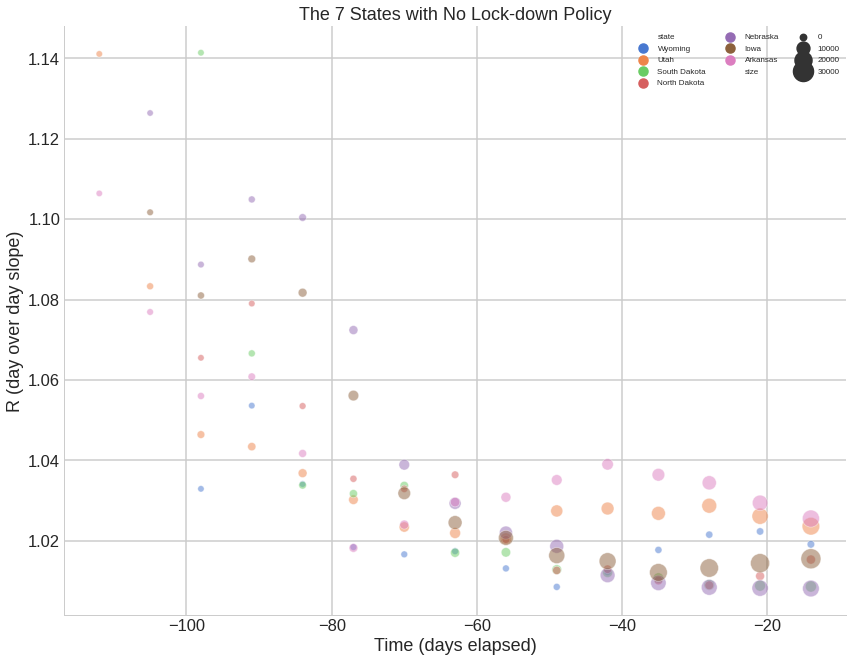

In [17]:
stateList = ['Arkansas', 'Iowa', 'Nebraska', 'North Dakota', 
          'South Dakota', 'Utah',  'Wyoming']
stateCount = len(stateList)
plotStates (states_all_df.loc[states_all_df['state'].isin(stateList),],
            plotlyChart, "The "+ str(stateCount) 
            +" States with No Lock-down Policy")

## Now some select counties by states that are not doing well:
  * Arizona
  * Florida
  * Texas
  * California

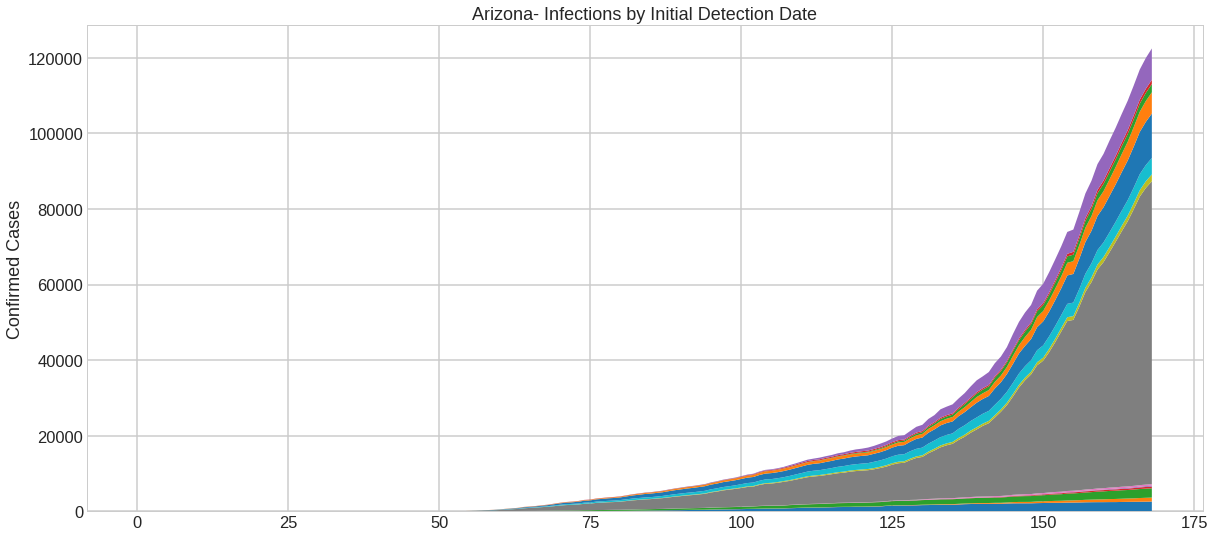

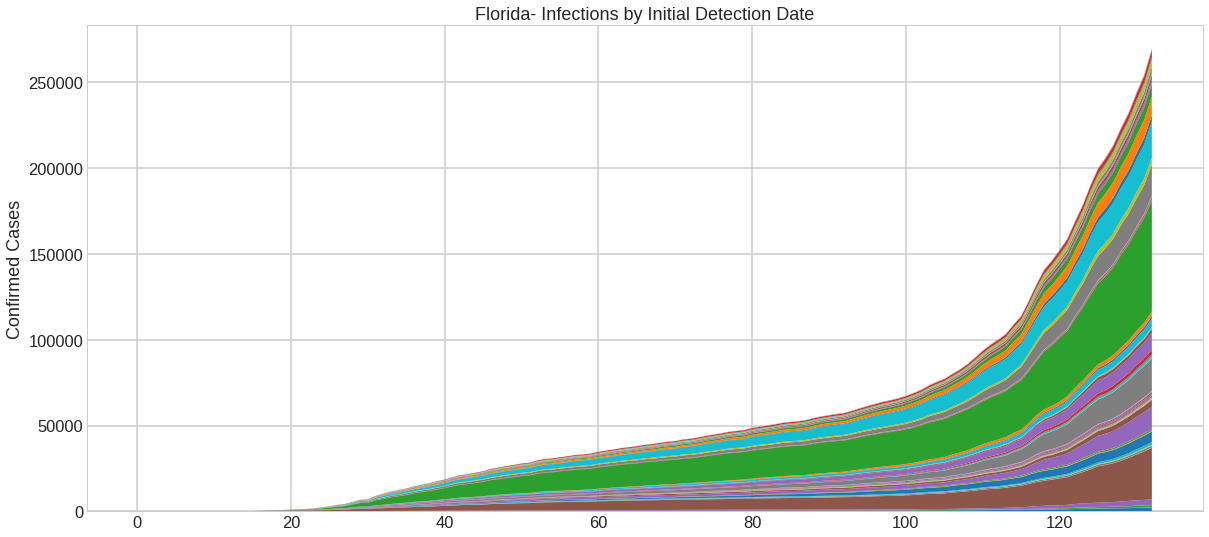

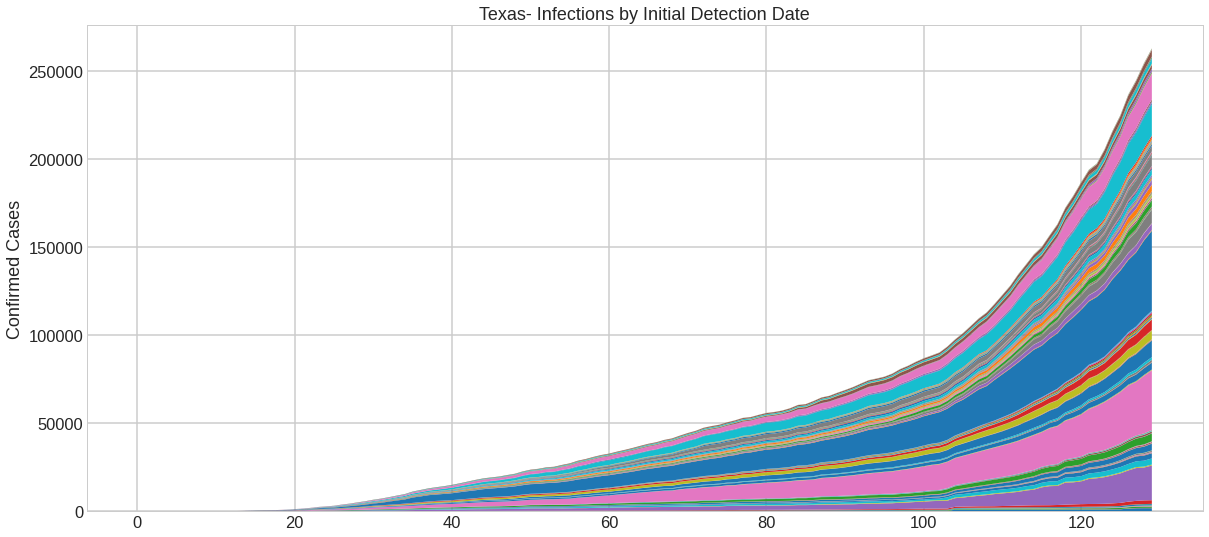

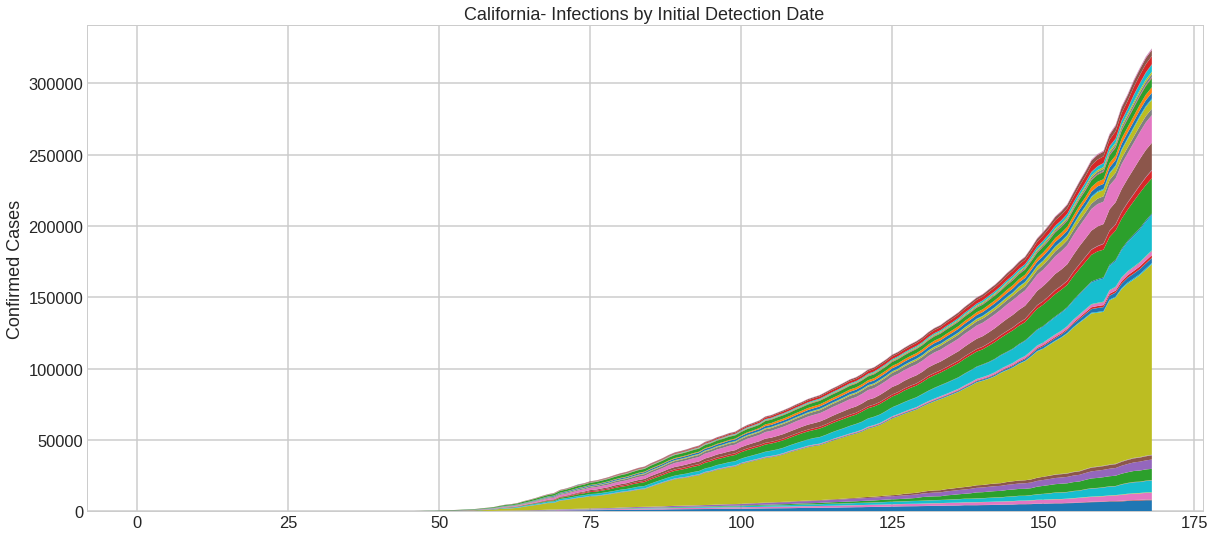

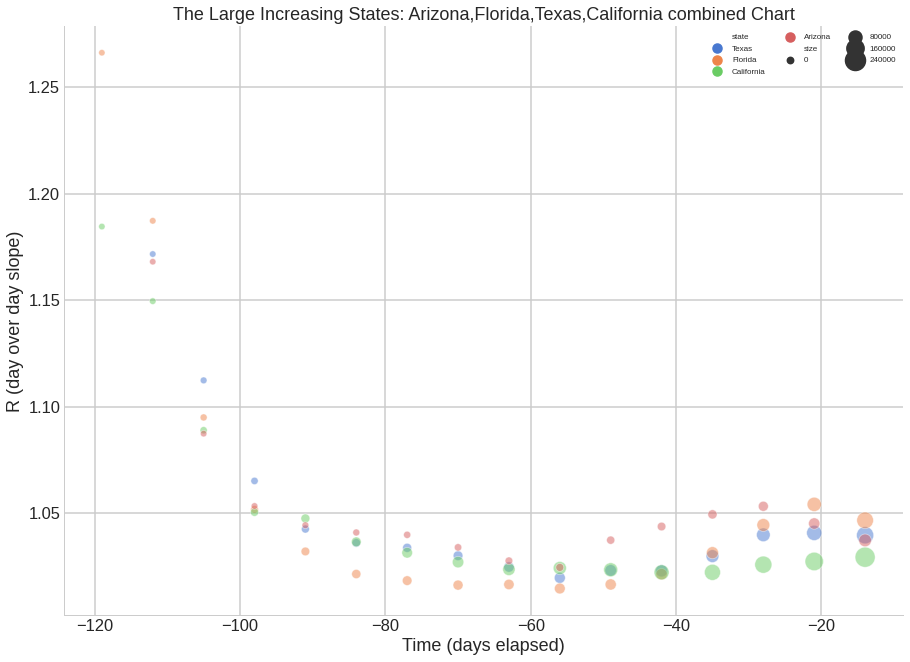

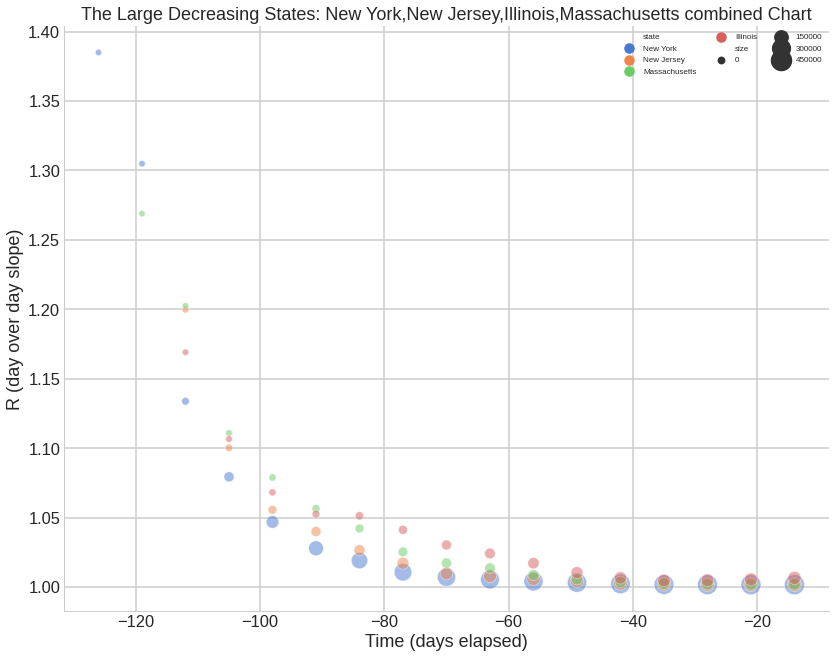

In [18]:
stateList = ['Arizona', 'Florida', 'Texas', 'California']
for stateName in stateList:
  plotStateGeo(stateName, stateName+"- Infections by Initial Detection Date", 
               plotlyChart )

plotStates (states_all_df.loc[states_all_df['state'].isin(stateList),],
            plotlyChart, "The Large Increasing States: "+ ",".join(stateList) 
            +" combined Chart")

stateList = ['New York', 'New Jersey', 'Illinois', 'Massachusetts']
plotStates (states_all_df.loc[states_all_df['state'].isin(stateList),],
            plotlyChart, "The Large Decreasing States: "+ ",".join(stateList) 
            +" combined Chart")

# Done

In [19]:
dateCols = confirmed_cases.columns.str.contains('/20')
colList = ['Admin2', 'Province_State'] + list(confirmed_cases.columns[dateCols])
l = confirmed_cases['Admin2'].notnull() & (confirmed_cases['1/30/20'] != 0)
confirmed_cases.loc[l, colList].head()

,Admin2,Province_State,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,...,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20
108,Maricopa,Arizona,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,11068,11229,12091,12761,13498,14003,14374,15282,16018,17010,17791,18692,19372,20775,22272,23880,25999,28303,30136,31650,33883,34992,37135,39626,42374,44962,45178,48592,52266,54757,57929,59829,62296,64915,67543,70128,73165,76328,78481,80146
209,Los Angeles,California,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,58261,59692,61068,62382,63844,64690,65945,67111,68959,70529,72057,73018,73832,75162,77260,78348,79655,81709,83414,86017,88512,89633,91577,93391,95385,97918,100958,103850,105665,107792,107806,107826,115024,116570,120764,123256,124992,127439,130394,133549
220,Orange,California,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,6678,6783,7064,7321,7440,7527,7614,7737,7987,8153,8269,8573,8759,8999,9197,9292,9576,9988,10422,10595,10737,11016,11511,11960,12462,12608,13064,13843,14413,15065,15778,16191,16854,17882,18892,20225,21517,22650,23901,24715
615,Cook,Illinois,0,0,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,80204,80713,81344,81924,82427,82819,83271,83585,83978,84249,84581,84906,85184,85538,85858,86179,86551,86885,87177,87424,87784,88138,88650,89068,89407,89755,90122,90536,90911,91381,91774,92240,92532,92781,93053,93496,94005,94605,95138,95557
2974,King,Washington,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,8264,8318,8371,8417,8457,8496,8529,8529,8550,8611,8694,8722,8785,8850,8885,8963,9061,9154,9211,9253,9366,9453,9573,9672,9809,9895,10019,10177,10304,10535,10684,10782,10941,11105,11182,11284,11419,11568,11568,11825


5
Slope: 0.16162984837800132
Intercept: 1.1313138746404516


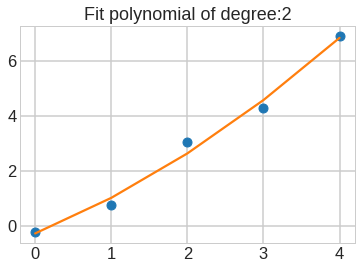

In [20]:
N = 5
y_func = [float(x)**(1.36) for x in range(0,N)]
np.random.seed(1729)

x = np.arange(0,N)
print (x.size)
y_noise = 0.3 * np.random.normal(size=x.size)
y = y_func + y_noise

polynomialDegree = 2
trend = np.polyfit(x,y,polynomialDegree)
plt.plot(x,y,'o')

print ('Slope:', trend[0])
print ('Intercept:', trend[1])

trendpoly = np.poly1d(trend) 
plt.plot(x,trendpoly(x))
plt.title('Fit polynomial of degree:'+str(polynomialDegree))
plt.show()